# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [ ]:
!mkdir cifar10
!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz -C cifar10

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

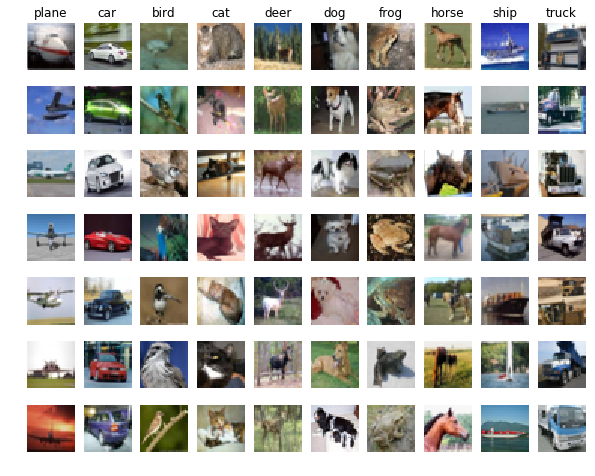

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

<Ответ>

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

<Ответ>

**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить?

<Ответ>

**Вопрос 4**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

<Ответ>

**Вопрос 5**: Как сделать стайл трансфер для музыки? oO

<Ответ>

In [4]:
import theano
theano.__version__

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 5105)


'0.9.0.dev-c697eeab84e5b8a74908da654b66ec9eca4f1291'

In [ ]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- http://www.robots.ox.ac.uk/~vgg/research/very_deep/
- https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Wish you get fun :)

# 1) Data augmentation

In [ ]:
# 1 - вычтем среднее значение пикселей
X_train /= 255.0
np.max(X_train)

In [ ]:
X_test /= 255.0
np.max(X_test)

In [ ]:
pixel_mean = np.mean(X_train[0:50000],axis=0)
X_train -= pixel_mean
np.mean(X_train)

In [ ]:
pixel_mean = np.mean(X_test[0:10000],axis=0)
X_test -= pixel_mean
np.mean(X_test)

In [ ]:
X_train = np.array(X_train, dtype = np.float32)
X_test = np.array(X_test, dtype = np.float32)

In [ ]:
y_train = np.array(y_train, dtype = np.int32)
y_test = np.array(y_test, dtype = np.int32)

# 2) Wide residual network architecture

In [ ]:
import sys
sys.setrecursionlimit(10000)
import lasagne
from lasagne.nonlinearities import rectify, softmax, sigmoid
from lasagne.layers import InputLayer, MaxPool2DLayer, DenseLayer, DropoutLayer, helper, batch_norm, BatchNormLayer
# for ResNet
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer, ElemwiseSumLayer, NonlinearityLayer, PadLayer, GlobalPoolLayer, ExpressionLayer
from lasagne.init import Orthogonal, HeNormal, GlorotNormal

In [ ]:
PIXELS = 32
imageSize = PIXELS * PIXELS
num_features = imageSize * 3
he_norm = HeNormal(gain='relu')

In [ ]:
def ResNet_FullPre_Wide(input_var=None, n=6, k=4):
    '''
    Adapted from https://github.com/Lasagne/Recipes/tree/master/papers/deep_residual_learning.
    Tweaked to be consistent with 'Identity Mappings in Deep Residual Networks', Kaiming He et al. 2016 (https://arxiv.org/abs/1603.05027)
    And 'Wide Residual Networks', Sergey Zagoruyko, Nikos Komodakis 2016 (http://arxiv.org/pdf/1605.07146v1.pdf)
    Depth = 6n + 2
    '''
    n_filters = {0:16, 1:16*k, 2:32*k, 3:64*k}

    # create a residual learning building block with two stacked 3x3 convlayers as in paper
    def residual_block(l, increase_dim=False, projection=True, first=False, filters=16):
        if increase_dim:
            first_stride = (2,2)
        else:
            first_stride = (1,1)

        if first:
            # hacky solution to keep layers correct
            bn_pre_relu = l
        else:
            # contains the BN -> ReLU portion, steps 1 to 2
            bn_pre_conv = BatchNormLayer(l)
            bn_pre_relu = NonlinearityLayer(bn_pre_conv, rectify)

        # contains the weight -> BN -> ReLU portion, steps 3 to 5
        conv_1 = batch_norm(ConvLayer(bn_pre_relu, num_filters=filters, filter_size=(3,3), stride=first_stride, nonlinearity=rectify, pad='same', W=he_norm))

        #dropout = DropoutLayer(conv_1, p=0.3)

        # contains the last weight portion, step 6
        conv_2 = ConvLayer(conv_1, num_filters=filters, filter_size=(3,3), stride=(1,1), nonlinearity=None, pad='same', W=he_norm)

        # add shortcut connections
        if increase_dim:
            # projection shortcut, as option B in paper
            projection = ConvLayer(bn_pre_relu, num_filters=filters, filter_size=(1,1), stride=(2,2), nonlinearity=None, pad='same', b=None)
            block = ElemwiseSumLayer([conv_2, projection])

        elif first:
            # projection shortcut, as option B in paper
            projection = ConvLayer(l, num_filters=filters, filter_size=(1,1), stride=(1,1), nonlinearity=None, pad='same', b=None)
            block = ElemwiseSumLayer([conv_2, projection])

        else:
            block = ElemwiseSumLayer([conv_2, l])

        return block

    # Building the network
    l_in = InputLayer(shape=(None, 3, PIXELS, PIXELS), input_var=input_var)

    # first layer, output is 16 x 64 x 64
    l = batch_norm(ConvLayer(l_in, num_filters=n_filters[0], filter_size=(3,3), stride=(1,1), nonlinearity=rectify, pad='same', W=he_norm))

    # first stack of residual blocks, output is 32 x 64 x 64
    l = residual_block(l, first=True, filters=n_filters[1])
    for _ in range(1,n):
        l = residual_block(l, filters=n_filters[1])

    # second stack of residual blocks, output is 64 x 32 x 32
    l = residual_block(l, increase_dim=True, filters=n_filters[2])
    for _ in range(1,(n+2)):
        l = residual_block(l, filters=n_filters[2])

    # third stack of residual blocks, output is 128 x 16 x 16
    l = residual_block(l, increase_dim=True, filters=n_filters[3])
    for _ in range(1,(n+2)):
        l = residual_block(l, filters=n_filters[3])

    bn_post_conv = BatchNormLayer(l)
    bn_post_relu = NonlinearityLayer(bn_post_conv, rectify)

    # average pooling
    avg_pool = GlobalPoolLayer(bn_post_relu)

    # fully connected layer
    network = DenseLayer(avg_pool, num_units=10, W=HeNormal(), nonlinearity=softmax)

    return network

In [ ]:
output_layer = ResNet_FullPre_Wide(input_X, n=2, k=4)

In [ ]:
output = lasagne.layers.get_output(output_layer)
output_test = lasagne.layers.get_output(output_layer, deterministic=True)

all_weights = lasagne.layers.get_all_params(output_layer)
print all_weights

In [ ]:
from lasagne.updates import nesterov_momentum, adam
from lasagne.layers import helper

In [ ]:
# set up the loss that we aim to minimize when using cat cross entropy our Y should be ints not one-hot
loss = lasagne.objectives.categorical_crossentropy(output, target_y)
loss = loss.mean()

In [ ]:
# set up loss functions for validation dataset
test_loss = lasagne.objectives.categorical_crossentropy(output_test, target_y)
test_loss = test_loss.mean()

In [ ]:
accuracy = T.mean(T.eq(T.argmax(output, axis=1), target_y), dtype=theano.config.floatX)

In [ ]:
# training params
ITERS = 100
BATCHSIZE = 128

LR_SCHEDULE = {
    0: 0.01,
    10: 0.1,
    80: 0.01,
    120: 0.001,
}

In [ ]:
l_r = theano.shared(np.array(LR_SCHEDULE[0], dtype=theano.config.floatX))

In [ ]:
params = lasagne.layers.get_all_params(output_layer, trainable=True)
updates = nesterov_momentum(loss, params, learning_rate=l_r, momentum=0.9)

In [ ]:
train_fun = theano.function([input_X,target_y], [loss, accuracy], updates=updates)
accuracy_fun = theano.function([input_X,target_y], accuracy)

### Вот и всё, пошли её учить

In [ ]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False, augment=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if augment:
            # as in paper : 
            # pad feature arrays with 4 pixels on each side
            # and do random cropping of 32x32
            padded = np.pad(inputs[excerpt],((0,0),(0,0),(4,4),(4,4)),mode='constant')
            random_cropped = np.zeros(inputs[excerpt].shape, dtype=np.float32)
            # flip left-right choice
            flip_lr = np.random.randint(0,1,size=(batchsize))
            crops = np.random.random_integers(0,high=8,size=(batchsize,2))
            for r in range(batchsize):
                cropped_img = padded[r,:,crops[r,0]:(crops[r,0]+32),crops[r,1]:(crops[r,1]+32)]
               
                # flip left-right if chosen
                if flip_lr[r] == 1:
                    cropped_img = np.fliplr(cropped_img)
                random_cropped[r,:,:,:] = cropped_img
                
            inp_exc = random_cropped
               
        else:
            inp_exc = inputs[excerpt]

        yield inp_exc, targets[excerpt]

In [ ]:
iterate_minibatches(X_train, y_train, BATCHSIZE, shuffle=True, augment=True).next()[0].shape

In [ ]:
X_val, y_val = X_test, y_test

# Процесс обучения

In [ ]:
import cPickle as pickle
import gzip

In [ ]:
# Если есть сохраненные чекпоинты, то грузим с них
start_batch = 7
f = gzip.open('weights/7_resnet.pklz', 'rb')
#f = open('weights/7_resnet.pklz', 'rb')

all_param_values = pickle.load(f)
f.close()
helper.set_all_param_values(output_layer, all_param_values)

In [ ]:
import time
import cPickle as pickle

# training params
ITERS = 100
BATCHSIZE = 128

LR_SCHEDULE = {
    0: 0.01,
    10: 0.1,
    80: 0.01,
    120: 0.001,
}

best_acc = 0.0

try:
    for epoch in range(start_batch, ITERS):
        # In each epoch, we do a full pass over the training data:

        # change learning rate according to schedules
        if epoch in LR_SCHEDULE:
            l_r.set_value(LR_SCHEDULE[epoch])

        train_err = 0
        train_acc = 0
        train_batches = 0
        start_time = time.time()
        
        for batch in iterate_minibatches(X_train, y_train, BATCHSIZE, shuffle=True, augment=True):
            inputs, targets = batch
            train_err_batch, train_acc_batch= train_fun(inputs, targets)
            train_err += train_err_batch
            train_acc += train_acc_batch
            train_batches += 1

        # And a full pass over the validation data:
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, BATCHSIZE):
            inputs, targets = batch
            val_acc += accuracy_fun(inputs, targets)
            val_batches += 1

        if val_acc / val_batches > best_acc:
            best_acc = val_acc / val_batches
            best_params = helper.get_all_param_values(output_layer)  
        
        if (epoch + 1) % 10 == 0:
            # save weights
            all_params = helper.get_all_param_values(output_layer)
            f = gzip.open('weights/%s_resnet.pklz'%(epoch + 1), 'wb')
            pickle.dump(best_params, f)
            f.close()
            
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, ITERS, time.time() - start_time))
        print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
        print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
        print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))
        
except KeyboardInterrupt:
    
    # save weights
    all_params = helper.get_all_param_values(output_layer)
    f = gzip.open('weights/%s_resnet.pklz'%(epoch + 1), 'wb')
    pickle.dump(best_params, f)
    f.close()

In [ ]:
all_params = helper.get_all_param_values(output_layer)
f = gzip.open('weights/%s_resnet.pklz'%(epoch+1), 'wb')
pickle.dump(best_params, f)
f.close()

In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 